# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [16]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [17]:
env = UnityEnvironment(file_name='../../Reacher_Windows_x86_64/Reacher.exe')
# env = UnityEnvironment(file_name='../../Reacher_Windows_x86_64_20/Reacher.exe')

OSError: handle is closed

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### 4.1 Train the Agent with DDPG

In [ ]:
from collections import deque
import matplotlib.pyplot as plt

import torch

from ddpg_agent import Agent
# agent = Agent(state_size=33, action_size=4, random_seed=42)
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using:", device)

#### Print the actor and critic network

In [ ]:
print(agent.actor_target)
print(agent.critic_target)

#### Define the DDPG algorithm

In [ ]:
def ddpg(n_episodes=3000, max_t=10000, print_every=100):
    """DDQN Algorithm.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): frequency of printing information throughout iteration """
    
    scores_deque = deque(maxlen=print_every)                # last 'print_every' scores
    scores = []                                             # all scores 
     
    for i_episode in range(1, n_episodes+1):                # iterate over episodes
        env_info = env.reset(train_mode=True)[brain_name]   # reset the environment 
        state = env_info.vector_observations[0]             # get the current state
        agent.reset()                                       # reset the agent
        score = 0                                           # reset the score
        
        
        for t in range(max_t):                              # iterate over time steps 
            action = agent.act(state)                       # select an action
            env_info = env.step(action)[brain_name]         # send action to tne environment
            
            next_state = env_info.vector_observations[0]    # next state  
            reward = env_info.rewards[0]                    # reward
            done = env_info.local_done[0]                   # dee if episode finished

            agent.step(state, action, reward, next_state, done) # take step with agent (including learning)

            score += reward                                 # update the score
            state = next_state                              #roll over the state to next time step 
            
            if done:                                        # exit loop if episode finished
                break 
        
        scores_deque.append(score)                         # save most recent score
        scores.append(score)
        
        # Save Actor & Critic Weights 
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        # Print current episode, score, and average of last 'print_every' scores
        print('\rEpisode {} \tScore: {:.2f} \tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))
        
        # Environment solved when average of last 100 scores is greater or equal to 30
        if np.mean(scores_deque) >= 30.0: 
            print('Environment solved in {:d} episodes! Average score of {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

scores = ddpg()

ERROR:root:Exception calling application: [WinError 232] Die Pipe wird gerade geschlossen
Traceback (most recent call last):
  File "C:\Users\Master\.conda\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\Master\.conda\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "C:\Users\Master\.conda\envs\drlnd\lib\multiprocessing\connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "C:\Users\Master\.conda\envs\drlnd\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] Die Pipe wird gerade geschlossen


#### Plot of Rewards

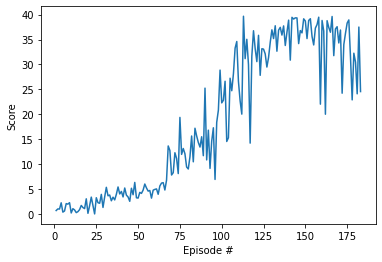

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5 Load the model parameter in the neural network and test the agent

Set train_mode=False


In [9]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

<All keys matched successfully>

In [10]:
env.reset(train_mode=False)[brain_name]            # reset the environment  
state = env_info.vector_observations[0]            # get the current state  
score = 0                                          # initialize the score

for t in range(10000):   
    action = agent.act(state, add_noise=False)     # select an action      
    env_info = env.step(action)[brain_name]        # send all actions to tne environment
    next_state = env_info.vector_observations[0]   # get next state         
    reward = env_info.rewards[0]                   # get reward
    done = env_info.local_done[0]                  # see if episode finished
    state = next_state                             # roll over state to next time step
    score += reward                                # update the score
    print('Score:', score, end='\r') 
    
    if done:                                       # exit loop if episode finished
        break

C:\Users\Master\.conda\envs\drlnd\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### 6. Close the environment at the end.

In [15]:
env.close()